### 할당된 GPU 확인

In [1]:
!nvidia-smi

Tue Jun 15 03:59:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

### 필요한 library 및 자료 다운로드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 97kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 4.2MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595693 sha256=d2ec1060709dccc8f5a9dba1c1ec548dbd4bd662a6f0460783c40d9d061534e9
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 4.1MB/s 
     |████████████████████████████████| 2.3MB 4.2MB/s 
     |████████████████████████████████| 3.3MB 23.1MB/s 
     |████████████████████████████████| 901kB 54.5MB/s 


In [4]:
#!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [6]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [7]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [8]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [10]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber_8_label_single.csv'

In [11]:
df = pd.read_csv(file2)

In [12]:
#라벨의 숫자화
label = df['tag'].values
encoder = LabelEncoder()
encoder.fit(label)

LabelEncoder()

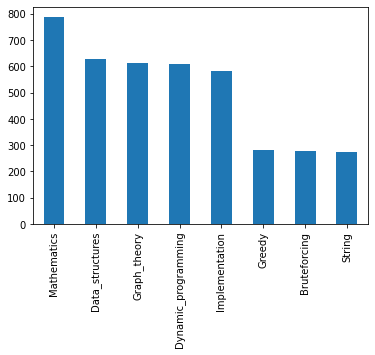

['Bruteforcing' 'Data_structures' 'Dynamic_programming' 'Graph_theory'
 'Greedy' 'Implementation' 'Mathematics' 'String']
tensor([1.8255, 0.8068, 0.8333, 0.8279, 1.7933, 0.8690, 0.6440, 1.8388])


In [13]:
df.tag.value_counts().plot(kind='bar')
plt.show()

class_loss = [df.tag.value_counts()[i] for i in encoder.classes_ ]
class_weights = compute_class_weight('balanced', np.unique(df['tag']), df['tag'])
weights= torch.tensor(class_weights,dtype=torch.float)
print(encoder.classes_)
print(weights)

### 분류한 dataset을 형식에 맞게 변환하는 코드

In [14]:
def set_data(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   problem = row['desc_variabel_renumber_0']
   if not pd.isna(row['input_variabel_renumber_0']) :
      problem = problem + row['input_variabel_renumber_0']

   dataset.append([problem , tmp[i]])
   i = i + 1
  return dataset

In [15]:
dataset = set_data(df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [16]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 관련 코드

In [17]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [18]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 100

### 데이터 셋 표준화 과정

In [19]:
data_all = BERTDataset(dataset, 0, 1, tok, max_len, True, False)

In [20]:
dataloader = torch.utils.data.DataLoader(data_all, batch_size=batch_size, num_workers=4)

In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        op, _ = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        x = op[:,:16, :]
        y = op[:,-48:, :]
        output = torch.cat((x,y), dim = 1)
        
        return output

### bertmodel 할당

In [22]:
model = BERTClassifier(bertmodel).to(device) 

In [23]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# vector 뽑아내는 단계

In [24]:
output = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    output.extend(out.to('cpu').tolist())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


### bert output caching

In [25]:
df['vector'] = output

In [26]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7, stratify = df.tag.values)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5, stratify = remaining.tag.values)

In [27]:
def set_data_vector(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
    dataset.append([torch.tensor(row['vector']) , tmp[i]])
    i = i + 1
  return dataset

In [28]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5)

In [29]:
data_train = set_data_vector(train_df)
data_valid = set_data_vector(valid_df)
data_test = set_data_vector(test_df)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

### CNN define

In [30]:
learning_rate =  1e-4
num_epochs = 40

In [31]:
class Classifier(nn.Module):
    def __init__(self,
                 hidden_size = 768,
                 num_classes=8,
                 dr_rate=0.0):
       super(Classifier, self).__init__()
       #16, 2848
       #32, 5696
       self.kernel_num = 16
       self.conv1d_maxpooling1 = nn.Sequential(
          nn.Conv1d(hidden_size, self.kernel_num, 4, stride = 2),
          nn.ReLU(),
          nn.MaxPool1d(2, 1),
          nn.Dropout(dr_rate)
       )
       self.conv1d_maxpooling2 = nn.Sequential(
          nn.Conv1d(hidden_size, self.kernel_num,8, stride = 2),
          nn.ReLU(),
          nn.MaxPool1d(2, 1),
          nn.Dropout(dr_rate)
       )
       self.conv1d_maxpooling3 = nn.Sequential(
          nn.Conv1d(hidden_size, self.kernel_num, 16, stride = 2),
          nn.ReLU(),
          nn.MaxPool1d(2, 1),
          nn.Dropout(dr_rate)
       )
       
       self.classifier = nn.Linear(1312, num_classes)
    def forward(self, x) :
      out1 = self.conv1d_maxpooling1(x.transpose(1, 2))
      out2 = self.conv1d_maxpooling2(x.transpose(1, 2))
      out3 = self.conv1d_maxpooling3(x.transpose(1, 2))
      union = torch.cat((out1, out2, out3), 2)
      union = union.reshape(union.size(0), -1)
      return  self.classifier(union)

In [32]:
net = Classifier(num_classes=8, dr_rate = 0.1).to(device) 

In [33]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

In [34]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = weights).to(device)

In [35]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [36]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#학습

In [37]:
train_loss_values = []
validation_loss_values = [] 
train_acc_list = []
validation_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    net.train()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        vector = vector.to(device)
        label = label.long().to(device)
        out = net.forward(vector)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_list.append(train_acc / len(train_dataloader))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    net.eval()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(valid_dataloader)):
        vector = vector.float().to(device)
        label = label.long().to(device)
        out = net(vector)
        loss = loss_fn(out, label)
        
        validation_loss += loss.item() 
        test_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)
    validation_acc_list.append(test_acc / len(valid_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


epoch 1 batch id 1 loss 2.122239351272583 train acc 0.0
epoch 1 batch id 101 loss 2.096017360687256 train acc 0.09158415841584158
epoch 1 batch id 201 loss 2.0466859340667725 train acc 0.1044776119402985
epoch 1 batch id 301 loss 2.1001954078674316 train acc 0.13413621262458472

epoch 1 train acc 0.14501404494382023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 validation acc 0.2727272727272727


epoch 2 batch id 1 loss 2.100996732711792 train acc 0.375
epoch 2 batch id 101 loss 2.1113579273223877 train acc 0.2561881188118812
epoch 2 batch id 201 loss 2.055804491043091 train acc 0.2506218905472637
epoch 2 batch id 301 loss 2.1509852409362793 train acc 0.26204318936877075

epoch 2 train acc 0.2636938202247191



epoch 2 validation acc 0.288961038961039


epoch 3 batch id 1 loss 1.9943863153457642 train acc 0.25
epoch 3 batch id 101 loss 1.9444642066955566 train acc 0.2834158415841584
epoch 3 batch id 201 loss 2.0573513507843018 train acc 0.3034825870646766
epoch 3 batch id 301 loss 1.961385726928711 train acc 0.3239202657807309

epoch 3 train acc 0.32900280898876405



epoch 3 validation acc 0.3198051948051948


epoch 4 batch id 1 loss 1.8661386966705322 train acc 0.25
epoch 4 batch id 101 loss 1.8607267141342163 train acc 0.32054455445544555
epoch 4 batch id 201 loss 2.2446999549865723 train acc 0.3414179104477612
epoch 4 batch id 301 loss 1.9556622505187988 train acc 0.3600498338870432

epoch 4 train acc 0.36622191011235955



epoch 4 validation acc 0.32792207792207795


epoch 5 batch id 1 loss 1.7220475673675537 train acc 0.25
epoch 5 batch id 101 loss 1.6814441680908203 train acc 0.349009900990099
epoch 5 batch id 201 loss 2.124624729156494 train acc 0.3694029850746269
epoch 5 batch id 301 loss 1.7834259271621704 train acc 0.3903654485049834

epoch 5 train acc 0.3981741573033708



epoch 5 validation acc 0.3262987012987013


epoch 6 batch id 1 loss 1.663027286529541 train acc 0.25
epoch 6 batch id 101 loss 1.6105324029922485 train acc 0.400990099009901
epoch 6 batch id 201 loss 2.0364668369293213 train acc 0.4210199004975124
epoch 6 batch id 301 loss 1.8511143922805786 train acc 0.43521594684385384

epoch 6 train acc 0.43855337078651685



epoch 6 validation acc 0.3068181818181818


epoch 7 batch id 1 loss 1.6283727884292603 train acc 0.25
epoch 7 batch id 101 loss 1.4452239274978638 train acc 0.42698019801980197
epoch 7 batch id 201 loss 1.952059030532837 train acc 0.4527363184079602
epoch 7 batch id 301 loss 1.630419373512268 train acc 0.46470099667774084

epoch 7 train acc 0.4691011235955056



epoch 7 validation acc 0.31006493506493504


epoch 8 batch id 1 loss 1.4666130542755127 train acc 0.375
epoch 8 batch id 101 loss 1.3271491527557373 train acc 0.49504950495049505
epoch 8 batch id 201 loss 2.0320441722869873 train acc 0.5099502487562189
epoch 8 batch id 301 loss 1.503087043762207 train acc 0.5220099667774086

epoch 8 train acc 0.5245786516853933



epoch 8 validation acc 0.29707792207792205


epoch 9 batch id 1 loss 1.390901803970337 train acc 0.375
epoch 9 batch id 101 loss 1.2464410066604614 train acc 0.5445544554455446
epoch 9 batch id 201 loss 1.7140257358551025 train acc 0.5541044776119403
epoch 9 batch id 301 loss 1.4643356800079346 train acc 0.5651993355481728

epoch 9 train acc 0.5663623595505618



epoch 9 validation acc 0.30194805194805197


epoch 10 batch id 1 loss 1.3463488817214966 train acc 0.375
epoch 10 batch id 101 loss 1.0483918190002441 train acc 0.5915841584158416
epoch 10 batch id 201 loss 1.5316376686096191 train acc 0.5963930348258707
epoch 10 batch id 301 loss 1.5025302171707153 train acc 0.606312292358804

epoch 10 train acc 0.605688202247191



epoch 10 validation acc 0.3116883116883117


epoch 11 batch id 1 loss 1.1678893566131592 train acc 0.625
epoch 11 batch id 101 loss 1.1101247072219849 train acc 0.6410891089108911
epoch 11 batch id 201 loss 1.545922875404358 train acc 0.6455223880597015
epoch 11 batch id 301 loss 1.4269686937332153 train acc 0.6524086378737541

epoch 11 train acc 0.648876404494382



epoch 11 validation acc 0.31493506493506496


epoch 12 batch id 1 loss 1.2056957483291626 train acc 0.625
epoch 12 batch id 101 loss 1.0278609991073608 train acc 0.6881188118811881
epoch 12 batch id 201 loss 1.3261643648147583 train acc 0.6865671641791045
epoch 12 batch id 301 loss 1.4825726747512817 train acc 0.6893687707641196

epoch 12 train acc 0.6889044943820225



epoch 12 validation acc 0.31006493506493504


epoch 13 batch id 1 loss 1.0717662572860718 train acc 0.625
epoch 13 batch id 101 loss 0.7700979113578796 train acc 0.7079207920792079
epoch 13 batch id 201 loss 1.2520575523376465 train acc 0.7176616915422885
epoch 13 batch id 301 loss 1.4156606197357178 train acc 0.7242524916943521

epoch 13 train acc 0.7212078651685393



epoch 13 validation acc 0.30194805194805197


epoch 14 batch id 1 loss 1.051337718963623 train acc 0.75
epoch 14 batch id 101 loss 0.6981925368309021 train acc 0.7363861386138614
epoch 14 batch id 201 loss 1.0781760215759277 train acc 0.746268656716418
epoch 14 batch id 301 loss 1.248643398284912 train acc 0.7512458471760798

epoch 14 train acc 0.75



epoch 14 validation acc 0.3198051948051948


epoch 15 batch id 1 loss 0.9270281791687012 train acc 0.75
epoch 15 batch id 101 loss 0.6384016275405884 train acc 0.7574257425742574
epoch 15 batch id 201 loss 0.9200377464294434 train acc 0.7649253731343284
epoch 15 batch id 301 loss 1.2822927236557007 train acc 0.7740863787375415

epoch 15 train acc 0.7707162921348315



epoch 15 validation acc 0.33116883116883117


epoch 16 batch id 1 loss 0.6797686219215393 train acc 0.75
epoch 16 batch id 101 loss 0.6452293395996094 train acc 0.7970297029702971
epoch 16 batch id 201 loss 0.8323792815208435 train acc 0.8003731343283582
epoch 16 batch id 301 loss 1.1619387865066528 train acc 0.8035714285714286

epoch 16 train acc 0.800561797752809



epoch 16 validation acc 0.336038961038961


epoch 17 batch id 1 loss 0.7973334193229675 train acc 0.75
epoch 17 batch id 101 loss 0.5140582323074341 train acc 0.8118811881188119
epoch 17 batch id 201 loss 0.7155558466911316 train acc 0.8165422885572139
epoch 17 batch id 301 loss 1.298158049583435 train acc 0.8272425249169435

epoch 17 train acc 0.8247893258426966



epoch 17 validation acc 0.33766233766233766


epoch 18 batch id 1 loss 0.6294304728507996 train acc 0.75
epoch 18 batch id 101 loss 0.39543360471725464 train acc 0.8193069306930693
epoch 18 batch id 201 loss 0.7995767593383789 train acc 0.8227611940298507
epoch 18 batch id 301 loss 1.3167724609375 train acc 0.8322259136212624

epoch 18 train acc 0.8293539325842697



epoch 18 validation acc 0.349025974025974


epoch 19 batch id 1 loss 0.5517398715019226 train acc 0.75
epoch 19 batch id 101 loss 0.41310951113700867 train acc 0.8502475247524752
epoch 19 batch id 201 loss 0.5763255953788757 train acc 0.8488805970149254
epoch 19 batch id 301 loss 1.1930407285690308 train acc 0.8567275747508306

epoch 19 train acc 0.8539325842696629



epoch 19 validation acc 0.3409090909090909


epoch 20 batch id 1 loss 0.5741110444068909 train acc 0.75
epoch 20 batch id 101 loss 0.540919840335846 train acc 0.8539603960396039
epoch 20 batch id 201 loss 0.6442563533782959 train acc 0.8606965174129353
epoch 20 batch id 301 loss 1.2963192462921143 train acc 0.8679401993355482

epoch 20 train acc 0.8651685393258427



epoch 20 validation acc 0.36038961038961037


epoch 21 batch id 1 loss 0.45056816935539246 train acc 0.875
epoch 21 batch id 101 loss 0.5554987192153931 train acc 0.8663366336633663
epoch 21 batch id 201 loss 0.6037253737449646 train acc 0.8725124378109452
epoch 21 batch id 301 loss 0.9555854201316833 train acc 0.8812292358803987

epoch 21 train acc 0.8802668539325843



epoch 21 validation acc 0.36688311688311687


epoch 22 batch id 1 loss 0.31195250153541565 train acc 1.0
epoch 22 batch id 101 loss 0.33576247096061707 train acc 0.8811881188118812
epoch 22 batch id 201 loss 0.5805720686912537 train acc 0.8855721393034826
epoch 22 batch id 301 loss 1.1461565494537354 train acc 0.8932724252491694

epoch 22 train acc 0.8879915730337079



epoch 22 validation acc 0.3587662337662338


epoch 23 batch id 1 loss 0.3341563045978546 train acc 1.0
epoch 23 batch id 101 loss 0.303169846534729 train acc 0.8873762376237624
epoch 23 batch id 201 loss 0.4505433738231659 train acc 0.8917910447761194
epoch 23 batch id 301 loss 1.0251460075378418 train acc 0.8999169435215947

epoch 23 train acc 0.8999297752808989



epoch 23 validation acc 0.37337662337662336


epoch 24 batch id 1 loss 0.449861615896225 train acc 0.875
epoch 24 batch id 101 loss 0.3400252163410187 train acc 0.8997524752475248
epoch 24 batch id 201 loss 0.43278902769088745 train acc 0.9092039800995025
epoch 24 batch id 301 loss 1.100110411643982 train acc 0.9127906976744186

epoch 24 train acc 0.9090589887640449



epoch 24 validation acc 0.38311688311688313


epoch 25 batch id 1 loss 0.2763741612434387 train acc 1.0
epoch 25 batch id 101 loss 0.3313864767551422 train acc 0.9071782178217822
epoch 25 batch id 201 loss 0.4538077414035797 train acc 0.9172885572139303
epoch 25 batch id 301 loss 1.17568838596344 train acc 0.920265780730897

epoch 25 train acc 0.9178370786516854



epoch 25 validation acc 0.38311688311688313


epoch 26 batch id 1 loss 0.16804248094558716 train acc 1.0
epoch 26 batch id 101 loss 0.242935448884964 train acc 0.9096534653465347
epoch 26 batch id 201 loss 0.38453465700149536 train acc 0.9210199004975125
epoch 26 batch id 301 loss 1.0544376373291016 train acc 0.925249169435216

epoch 26 train acc 0.9213483146067416



epoch 26 validation acc 0.37987012987012986


epoch 27 batch id 1 loss 0.3838942348957062 train acc 0.875
epoch 27 batch id 101 loss 0.2758234143257141 train acc 0.9096534653465347
epoch 27 batch id 201 loss 0.44463056325912476 train acc 0.9241293532338308
epoch 27 batch id 301 loss 0.9763643145561218 train acc 0.9248338870431894

epoch 27 train acc 0.920997191011236



epoch 27 validation acc 0.375


epoch 28 batch id 1 loss 0.18724362552165985 train acc 1.0
epoch 28 batch id 101 loss 0.4169730544090271 train acc 0.9232673267326733
epoch 28 batch id 201 loss 0.4683718681335449 train acc 0.9309701492537313
epoch 28 batch id 301 loss 1.0607036352157593 train acc 0.9323089700996677

epoch 28 train acc 0.9294241573033708



epoch 28 validation acc 0.375


epoch 29 batch id 1 loss 0.18204094469547272 train acc 1.0
epoch 29 batch id 101 loss 0.26689937710762024 train acc 0.9306930693069307
epoch 29 batch id 201 loss 0.4111686944961548 train acc 0.9347014925373134
epoch 29 batch id 301 loss 0.8974059224128723 train acc 0.9381229235880398

epoch 29 train acc 0.9339887640449438



epoch 29 validation acc 0.37012987012987014


epoch 30 batch id 1 loss 0.24293532967567444 train acc 1.0
epoch 30 batch id 101 loss 0.2776976525783539 train acc 0.9306930693069307
epoch 30 batch id 201 loss 0.35149386525154114 train acc 0.9378109452736318
epoch 30 batch id 301 loss 0.9947910904884338 train acc 0.9393687707641196

epoch 30 train acc 0.9371488764044944



epoch 30 validation acc 0.36363636363636365


epoch 31 batch id 1 loss 0.16154929995536804 train acc 1.0
epoch 31 batch id 101 loss 0.2179391086101532 train acc 0.9443069306930693
epoch 31 batch id 201 loss 0.28805112838745117 train acc 0.9446517412935324
epoch 31 batch id 301 loss 1.0505543947219849 train acc 0.9472591362126246

epoch 31 train acc 0.9424157303370787



epoch 31 validation acc 0.3652597402597403


epoch 32 batch id 1 loss 0.11770430207252502 train acc 1.0
epoch 32 batch id 101 loss 0.24004432559013367 train acc 0.9418316831683168
epoch 32 batch id 201 loss 0.3328348398208618 train acc 0.9458955223880597
epoch 32 batch id 301 loss 1.0177891254425049 train acc 0.9447674418604651

epoch 32 train acc 0.9438202247191011



epoch 32 validation acc 0.36363636363636365


epoch 33 batch id 1 loss 0.2281566560268402 train acc 1.0
epoch 33 batch id 101 loss 0.2136549949645996 train acc 0.943069306930693
epoch 33 batch id 201 loss 0.25509434938430786 train acc 0.9465174129353234
epoch 33 batch id 301 loss 0.8422117233276367 train acc 0.9439368770764119

epoch 33 train acc 0.9406601123595506



epoch 33 validation acc 0.3587662337662338


epoch 34 batch id 1 loss 0.15063416957855225 train acc 1.0
epoch 34 batch id 101 loss 0.2158736288547516 train acc 0.943069306930693
epoch 34 batch id 201 loss 0.38464558124542236 train acc 0.9477611940298507
epoch 34 batch id 301 loss 0.7547780275344849 train acc 0.9476744186046512

epoch 34 train acc 0.9431179775280899



epoch 34 validation acc 0.362012987012987


epoch 35 batch id 1 loss 0.10075010359287262 train acc 1.0
epoch 35 batch id 101 loss 0.21464025974273682 train acc 0.943069306930693
epoch 35 batch id 201 loss 0.26512324810028076 train acc 0.945273631840796
epoch 35 batch id 301 loss 0.7905243039131165 train acc 0.9460132890365448

epoch 35 train acc 0.9424157303370787



epoch 35 validation acc 0.35714285714285715


epoch 36 batch id 1 loss 0.14923278987407684 train acc 1.0
epoch 36 batch id 101 loss 0.16170459985733032 train acc 0.9443069306930693
epoch 36 batch id 201 loss 0.3945818841457367 train acc 0.9514925373134329
epoch 36 batch id 301 loss 0.8789029121398926 train acc 0.9543189368770764

epoch 36 train acc 0.9480337078651685



epoch 36 validation acc 0.3587662337662338


epoch 37 batch id 1 loss 0.13857737183570862 train acc 1.0
epoch 37 batch id 101 loss 0.1898328959941864 train acc 0.9566831683168316
epoch 37 batch id 201 loss 0.20971882343292236 train acc 0.9546019900497512
epoch 37 batch id 301 loss 0.6583068370819092 train acc 0.9539036544850499

epoch 37 train acc 0.9508426966292135



epoch 37 validation acc 0.36688311688311687


epoch 38 batch id 1 loss 0.12415572255849838 train acc 1.0
epoch 38 batch id 101 loss 0.1583799421787262 train acc 0.9455445544554455
epoch 38 batch id 201 loss 0.3322528600692749 train acc 0.9521144278606966
epoch 38 batch id 301 loss 0.857376754283905 train acc 0.9534883720930233

epoch 38 train acc 0.9504915730337079



epoch 38 validation acc 0.36688311688311687


epoch 39 batch id 1 loss 0.1357114315032959 train acc 1.0
epoch 39 batch id 101 loss 0.1734018325805664 train acc 0.9467821782178217
epoch 39 batch id 201 loss 0.3043335974216461 train acc 0.947139303482587
epoch 39 batch id 301 loss 0.8315283060073853 train acc 0.9526578073089701

epoch 39 train acc 0.9501404494382022



epoch 39 validation acc 0.3685064935064935


epoch 40 batch id 1 loss 0.14340394735336304 train acc 1.0
epoch 40 batch id 101 loss 0.22310683131217957 train acc 0.9504950495049505
epoch 40 batch id 201 loss 0.3065638542175293 train acc 0.9552238805970149
epoch 40 batch id 301 loss 0.6496874094009399 train acc 0.9559800664451827

epoch 40 train acc 0.952247191011236



epoch 40 validation acc 0.3717532467532468


### loss graph 그린다

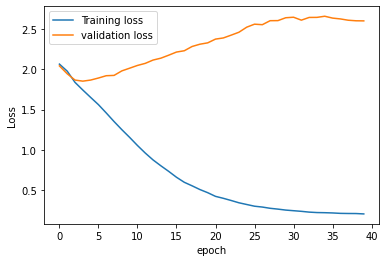

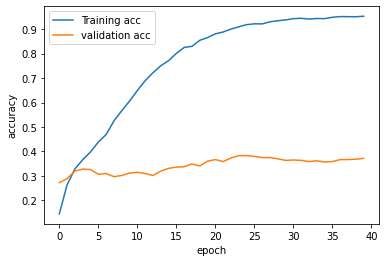

In [38]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(np.array(train_acc_list), label='Training acc')
plt.plot(np.array(validation_acc_list), label='validation acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### predict하는 코드

In [39]:
pred_list = []
test_label = []

with torch.no_grad():
  net.eval()
  for batch_id, (vector, label) in enumerate(tqdm_notebook(test_dataloader)):
    vector = vector.to(device)
    label = label.long().to(device)
    test_label.extend(label)
    out = net(vector)
    _, pred_value = torch.max(out, 1)
    pred_list.extend(pred_value.cpu().numpy())

pred_list = [a.squeeze().tolist() for a in pred_list]
test_label = [a.squeeze().tolist() for a in test_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


###성능분석

In [40]:
target_name = encoder.classes_
print(classification_report(test_label, pred_list, target_names=target_name, zero_division = 0))

                     precision    recall  f1-score   support

       Bruteforcing       0.12      0.06      0.08        53
    Data_structures       0.37      0.44      0.40        94
Dynamic_programming       0.28      0.32      0.30        71
       Graph_theory       0.50      0.52      0.51       100
             Greedy       0.12      0.06      0.08        34
     Implementation       0.37      0.41      0.39        86
        Mathematics       0.39      0.42      0.40       120
             String       0.53      0.49      0.51        51

           accuracy                           0.38       609
          macro avg       0.34      0.34      0.33       609
       weighted avg       0.36      0.38      0.37       609



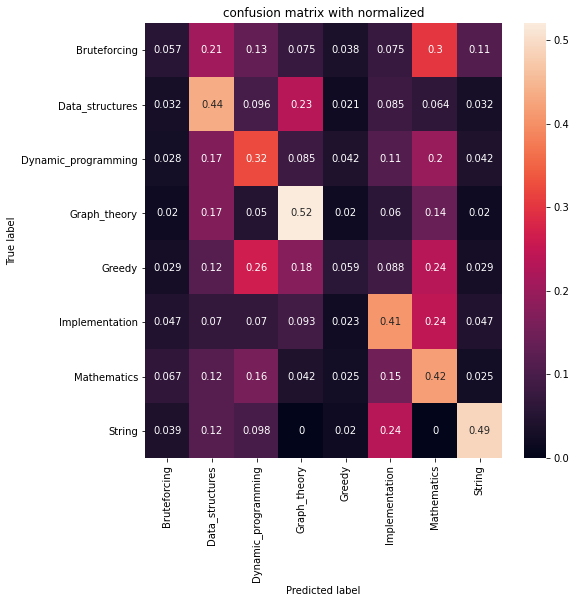

In [41]:
cm = confusion_matrix(test_label, pred_list)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(8, 8))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()